In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#%matplotlib notebook

In [3]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import (KMeans, AgglomerativeClustering)

SEED = 666

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

sns.set_style('white')

from audiovocana.conf import (FFTFREQS, MELFREQS)
from audiovocana.dataset import get_dataset

PLOT = True
RESULTS_FOLDER = "/home/utilisateur/Desktop/palomars/ultra-sonic-vocalizations/experiments/full-dataset/results"

/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


~~~~~~ AUDIOVOCANA SETTINGS ~~~~~~
AUDIOPARAMS 
 {'sr': 250000, 'mono': True}
STFTPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'win_length': 8192, 'center': True}
MELPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'n_mels': 128, 'fmin': 0, 'fmax': 125000.0, 'htk': True}
MFCCPAMARS 
 {'sr': 250000, 'n_mfcc': 13, 'dct_type': 2, 'norm': 'ortho', 'htk': True}
mel fiterbank shape = (128, 4097)
Minimun waveform length accepted is 4104 PCM points.
Minimun audio duration accepted is 16.416 miliseconds.
STFT time resolution = 32.768 ms.
STFT frequency resolution = 30.5101293629485 Hz.


In [4]:
csv_path = '/home/utilisateur/Desktop/palomars/data/dev/dataset.csv'
cache_folder = '/home/utilisateur/Desktop/palomars/cache/dev_dataset'
xlsx_folder = "/home/utilisateur/Desktop/palomars/data/dev"
audio_folder = "/home/utilisateur/Desktop/palomars/data/dev"

In [5]:
dataset = get_dataset(
    csv_path=csv_path,
    cache_folder=cache_folder,
    shuffle=False,
    recompute=False
)

Reading csv from /home/utilisateur/Desktop/palomars/data/dev/dataset.csv.
Found 377 events from 3 different experiments and 9 different recordings


In [7]:
vocs = np.array([sample['vocalization'] for sample in iter(dataset)])
postnataldays = np.array([sample['postnatalday'].numpy() for sample in iter(dataset)])
nests = np.array([sample['nest'].numpy() for sample in iter(dataset)])
recordings = np.array([sample['recording'].numpy() for sample in iter(dataset)])

dicc_vocs = {
    1: 'tab:blue',
    2: 'tab:orange'
}
colors_vocs = pd.DataFrame(vocs)[0].map(dicc_vocs)

dicc_recordings = {
    482: 'y',
    494: 'g',
    637: 'r'
} 
colors_recordings = pd.DataFrame(recordings)[0].map(dicc_recordings)

dicc_nests = {
    1: 'c',
    2: 'm'
}
colors_nest = pd.DataFrame(nests)[0].map(dicc_nests)

dicc_pnds = dict(zip(set(postnataldays),sns.color_palette("Blues", len(set(postnataldays)))))
colors_pnds = pd.DataFrame(postnataldays)[0].map(dicc_pnds)

colors = pd.concat([colors_vocs, colors_recordings, colors_nest, colors_pnds], axis=1)
colors.columns = ['vocalization', 'recording', 'nest', 'postnatalday']

Text(0.5, 1.0, 'VOCALIZATION TYPE')

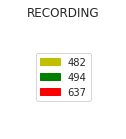

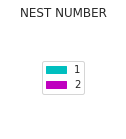

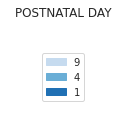

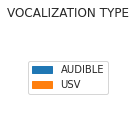

In [8]:
def plot_legend(colordicc, title):
    legend_elements = [Patch(facecolor=c, edgecolor=c, label=l) for l, c in colordicc.items()]
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.legend(handles=legend_elements, loc='center')
    plt.title(title)
    plt.axis('off')

plot_legend(dicc_recordings, 'RECORDING')
plot_legend(dicc_nests, 'NEST NUMBER')
plot_legend(dicc_pnds, 'POSTNATAL DAY')


legend_elements = [
    Patch(facecolor='tab:blue', edgecolor='tab:blue', label='AUDIBLE'),
    Patch(facecolor='tab:orange', edgecolor='tab:orange', label='USV')
]
fig, ax = plt.subplots(figsize=(2, 2))
ax.legend(handles=legend_elements, loc='center')
plt.axis('off')
plt.title('VOCALIZATION TYPE')

In [10]:
feats = dict()
for feat in  ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']: 
    feats[feat] = np.array([sample[feat] for sample in tqdm(iter(dataset))])

122it [00:00, 1092.73it/s]
122it [00:00, 1043.23it/s]
122it [00:00, 759.33it/s]
122it [00:00, 1015.91it/s]
122it [00:00, 1409.73it/s]
122it [00:00, 1426.12it/s]


In [11]:
xlabels =  np.array([
    str(sample['recording'].numpy())+'_'+str(sample['event'].numpy())
    for sample in iter(dataset)
])

dicc_xlabels = dict(zip(set([x[:3] for x in  xlabels]),  sns.xkcd_palette( ["amber", "greyish", "dusty purple"]) ))

In [82]:
def get_ylabels(name, num):
    if name == 'stft':
        return np.linspace(FFTFREQS[0], FFTFREQS[-1], num=num, dtype=np.int)
    elif name == '_mel':
        return np.linspace(MELFREQS[0], MELFREQS[-1], num=num, dtype=np.int)
    elif name == 'mfcc':
        return np.linspace(0, num, num=num, dtype=np.int)


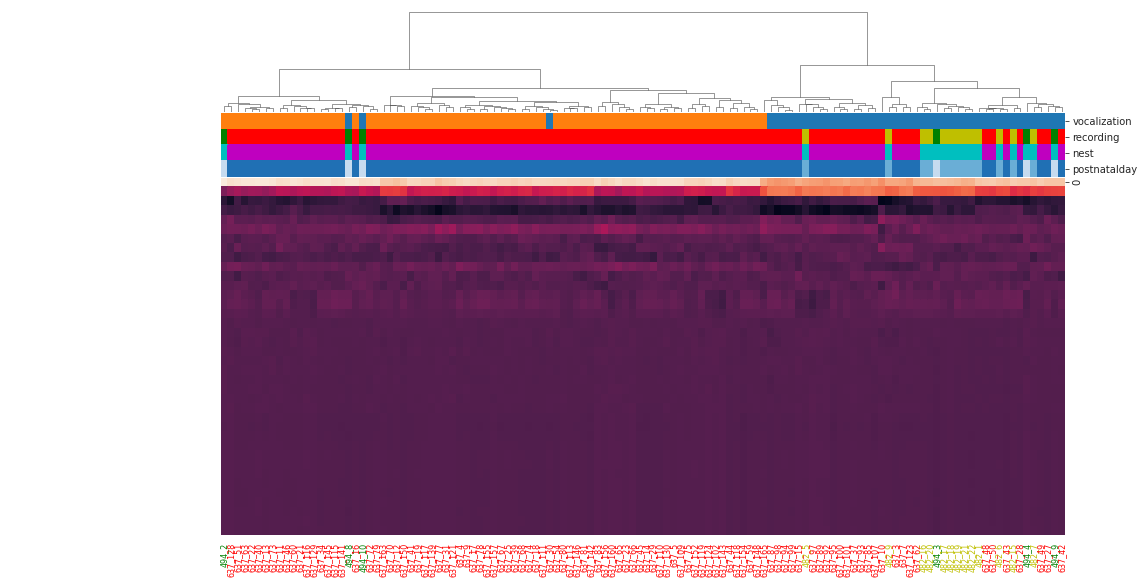

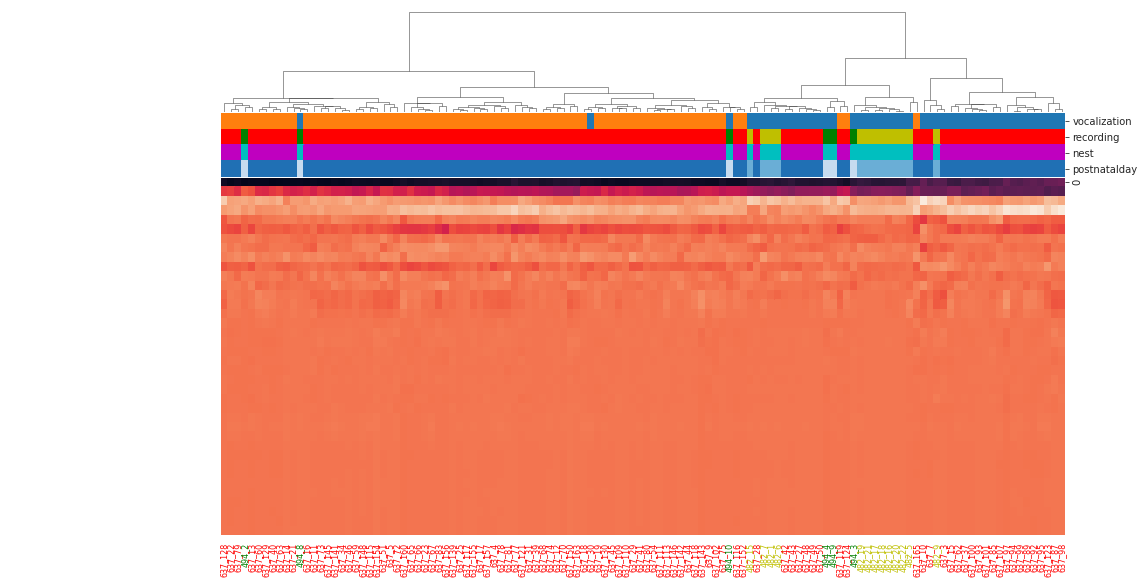

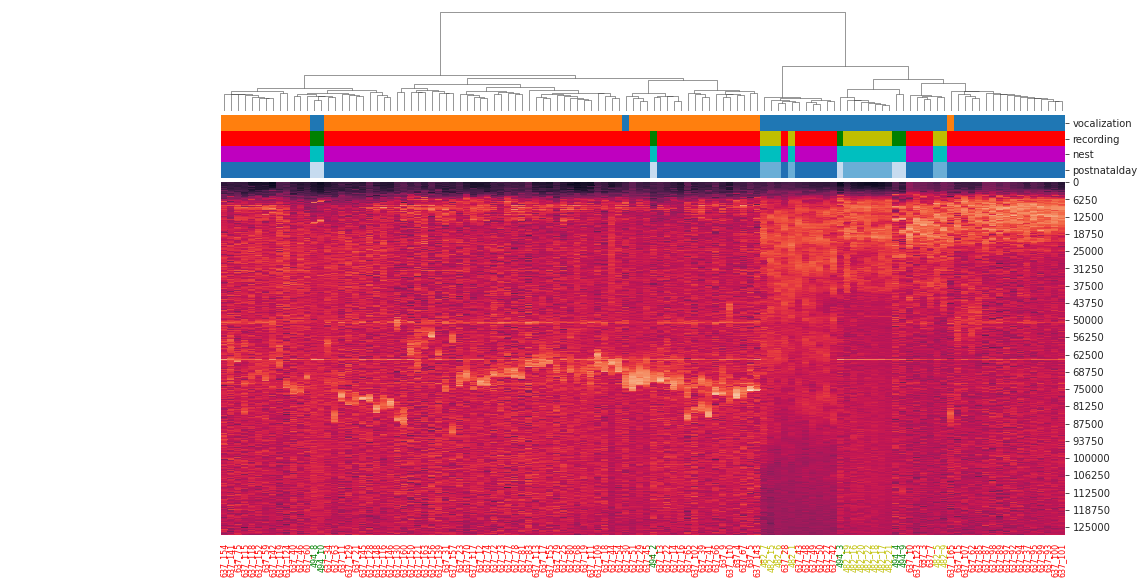

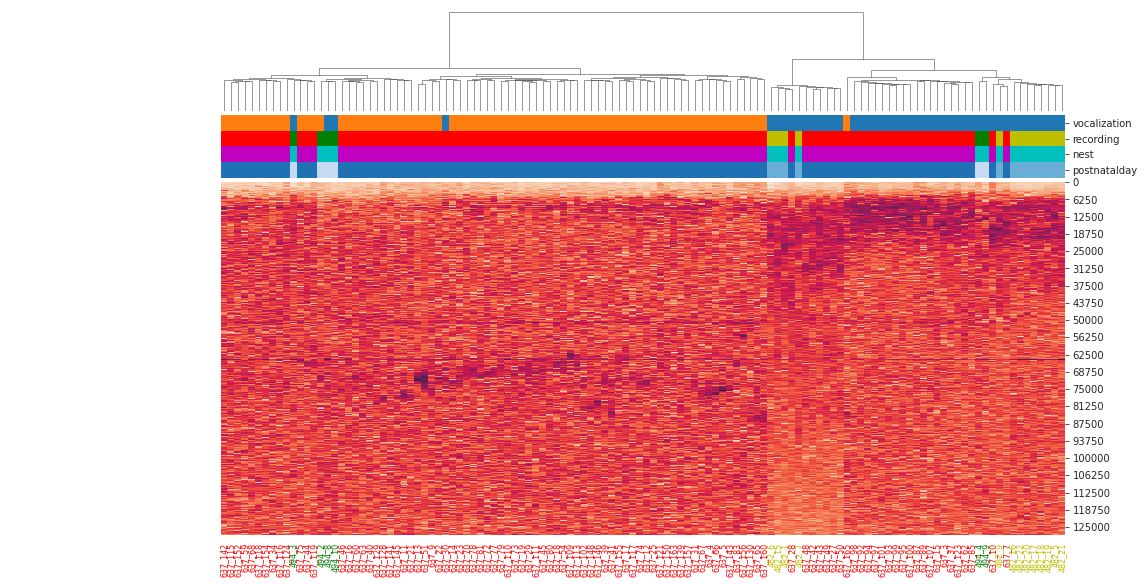

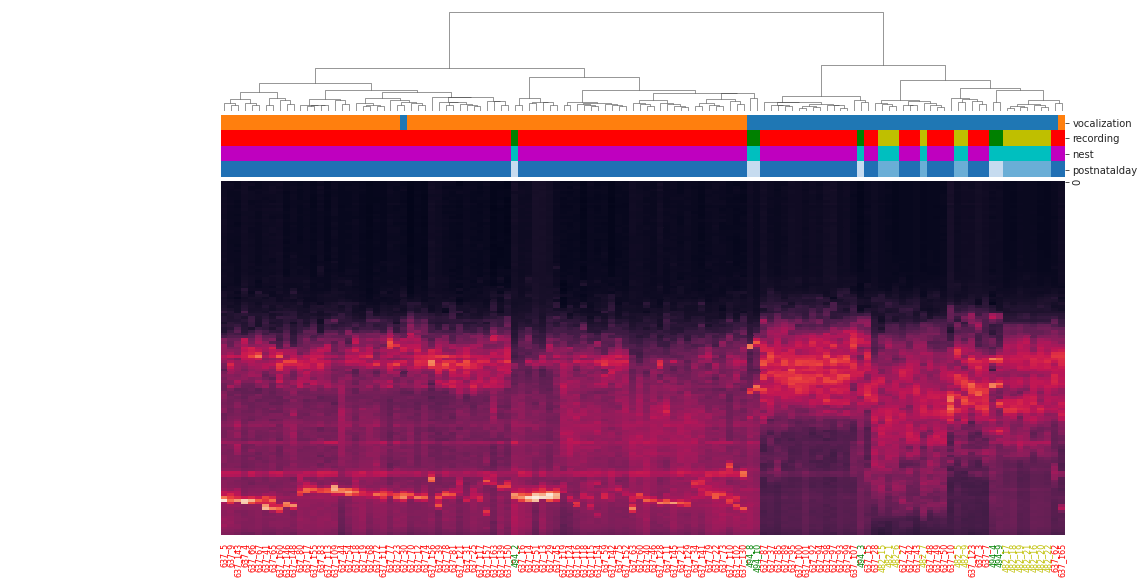

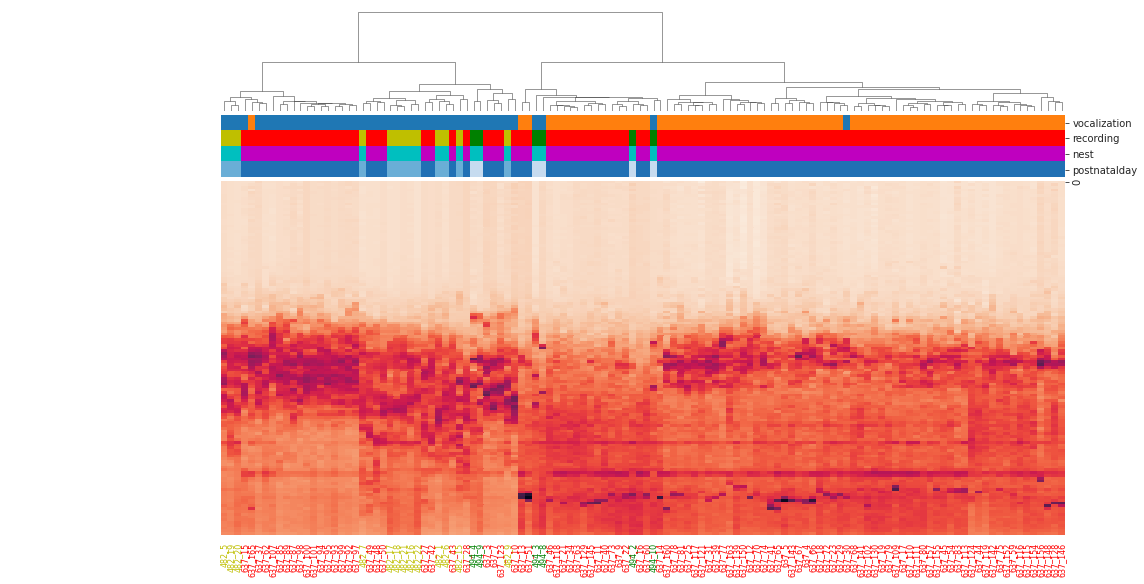

In [84]:
# https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
AFFINITY = "euclidean"  # "euclidean", "cosine", "sqeuclidean", "cityblock"
LINKAGE = "ward"  #  "ward", "complete", "average", "single"

for feat in ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']: 
    
    g = sns.clustermap(
        pd.DataFrame(feats[feat].T),
        method=LINKAGE,
        metric=AFFINITY,
        standard_scale=None, # Either 0 (rows) or 1 (columns) or None
        z_score=1, # Either 0 (rows) or 1 (columns) or None
        row_cluster=False,
        col_colors=colors,
        center=None, # check what this is, looks different with 0
        figsize=(16, 8),
        cbar_pos=None,
        xticklabels=1,
        yticklabels=200)
    
    g.ax_heatmap.axes.set_xticklabels([
       xlabels[int(x.get_text())]  for x in g.ax_heatmap.axes.get_xticklabels()
    ])
    
    for tick in g.ax_heatmap.axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(8) 
        tick.label.set_rotation('vertical')
        
             
    for tick_label in g.ax_heatmap.axes.get_xticklabels():
        tick_text = tick_label.get_text()
        tick_label.set_color(dicc_recordings[int(tick_text[:3])])
    

    for tick in g.ax_heatmap.axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(2) 
        tick.label.set_rotation('horizontal')

    g.ax_heatmap.axes.set_yticklabels(
        get_ylabels(
            name=feat[-4:],
            num=len(g.ax_heatmap.axes.yaxis.get_major_ticks())
        )
    )
        
    g.savefig(os.path.join(RESULTS_FOLDER, f"{feat}-clustermap.png"))